In [1]:
import logging
import pathlib
import sys

import pandas as pd

from topollm.analysis.compare_sampling_methods.make_plots import (
    create_boxplot_of_mean_over_different_sampling_seeds,
    generate_fixed_params_text,
)
from topollm.analysis.compare_sampling_methods.run_general_comparisons import (
    Y_AXIS_LIMITS_ONLY_FULL,
    filter_dataframe_based_on_filters_dict,
)
from topollm.config_classes.constants import TOPO_LLM_REPOSITORY_BASE_PATH

default_logger: logging.Logger = logging.getLogger(name=__name__)
# Add stdout handler to default logger
default_logger.addHandler(
    logging.StreamHandler(
        stream=sys.stdout,
    ),
)

logger: logging.Logger = default_logger

Setting HYDRA_FULL_ERROR environment variable to '1'.
os.environ['HYDRA_FULL_ERROR'] = '1'


In [2]:
comparisons_folder_base_path = pathlib.Path(
    TOPO_LLM_REPOSITORY_BASE_PATH,
    "data/analysis/sample_sizes/run_general_comparisons/array_truncation_size=5000/analysis/twonn/",
)

In [3]:
root_dir = comparisons_folder_base_path

# Initialize an empty list to store dataframes
dfs = []

# Traverse the directory structure using pathlib's rglob
for file_path in root_dir.rglob(pattern="full_local_estimates_df.csv"):
    # Load the CSV file into a dataframe
    df = None

    try:
        df = pd.read_csv(filepath_or_buffer=file_path, keep_default_na=False)
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

    # Append the dataframe to the list
    dfs.append(df)

# Concatenate the dataframes
if dfs:
    concatenated_df = pd.concat(dfs, ignore_index=True)
else:
    concatenated_df = pd.DataFrame()  # Empty dataframe if no files found

# Save the concatenated dataframe
output_path = pathlib.Path(root_dir, "concatenated_full_local_estimates_df.csv")
concatenated_df.to_csv(output_path, index=False)

print(f"Saved concatenated dataframe to {output_path = }")
print(f"{concatenated_df["model_partial_name"].unique() = }")

Saved concatenated dataframe to output_path = PosixPath('/Users/ruppik/git-source/Topo_LLM/data/analysis/sample_sizes/run_general_comparisons/array_truncation_size=5000/analysis/twonn/concatenated_full_local_estimates_df.csv')
concatenated_df["model_partial_name"].unique() = array(['model-model-roberta-base_task-masked_lm_multiwoz21-train-10000-ner_tags_ftm-standard_lora-None_5e-05-constant-0.01-50',
       'model-model-roberta-base_task-masked_lm_one-year-of-tsla-on-reddit-train-10000-ner_tags_ftm-standard_lora-None_5e-05-constant-0.01-50',
       'model-roberta-base'], dtype=object)


In [4]:
def create_histograms_over_model_checkpoints(
    concatenated_filters_dict: dict,
    plot_save_path: pathlib.Path | None = None,
    raw_data_save_path: pathlib.Path | None = None,
) -> None:
    filtered_concatenated_df = filter_dataframe_based_on_filters_dict(
        df=concatenated_df,
        filters_dict=concatenated_filters_dict,
    )

    # # # #
    # Filter for the dataframe with just the base model data

    same_filters_but_for_base_model = concatenated_filters_dict.copy()
    same_filters_but_for_base_model["model_partial_name"] = "model-roberta-base"

    filtered_for_base_model_concatenated_df = filter_dataframe_based_on_filters_dict(
        df=concatenated_df,
        filters_dict=same_filters_but_for_base_model,
    )

    # Set all the values in the "model_checkpoint" column to "-1"
    filtered_for_base_model_concatenated_df["model_checkpoint"] = -1

    # # # #
    # Create a dataframe by concatenating the two dataframes
    data_for_checkpoint_analysis_df = pd.concat(
        objs=[filtered_concatenated_df, filtered_for_base_model_concatenated_df],
        ignore_index=True,
    )

    # # # #
    # Group "data_for_checkpoint_analysis_df" by value in 'model_checkpoint' column
    # and make a boxplot of "array_data_truncated_mean" for each group

    fixed_params_text: str = generate_fixed_params_text(
        filters_dict=concatenated_filters_dict,
    )

    for y_min, y_max in Y_AXIS_LIMITS_ONLY_FULL.values():
        create_boxplot_of_mean_over_different_sampling_seeds(
            subset_local_estimates_df=data_for_checkpoint_analysis_df,
            plot_save_path=plot_save_path,
            raw_data_save_path=raw_data_save_path,
            x_column_name="model_checkpoint",
            y_column_name="array_data_truncated_mean",
            fixed_params_text=fixed_params_text,
            y_min=y_min,
            y_max=y_max,
            logger=logger,
        )

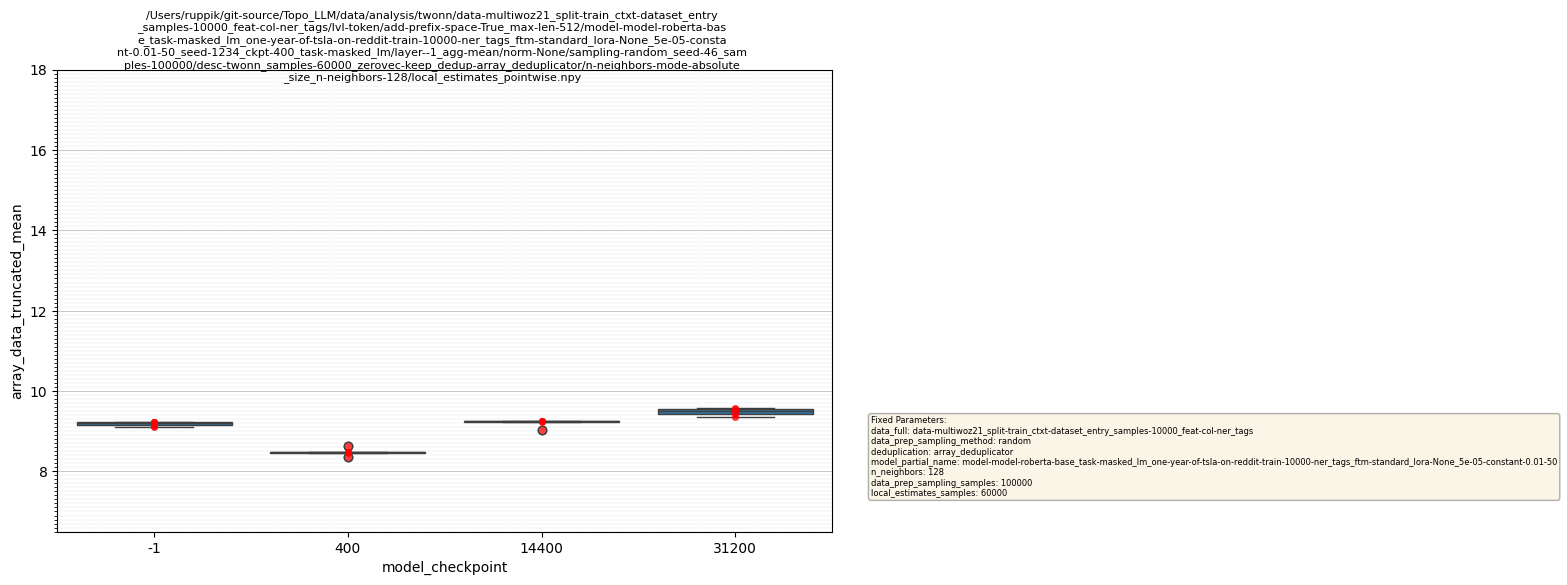

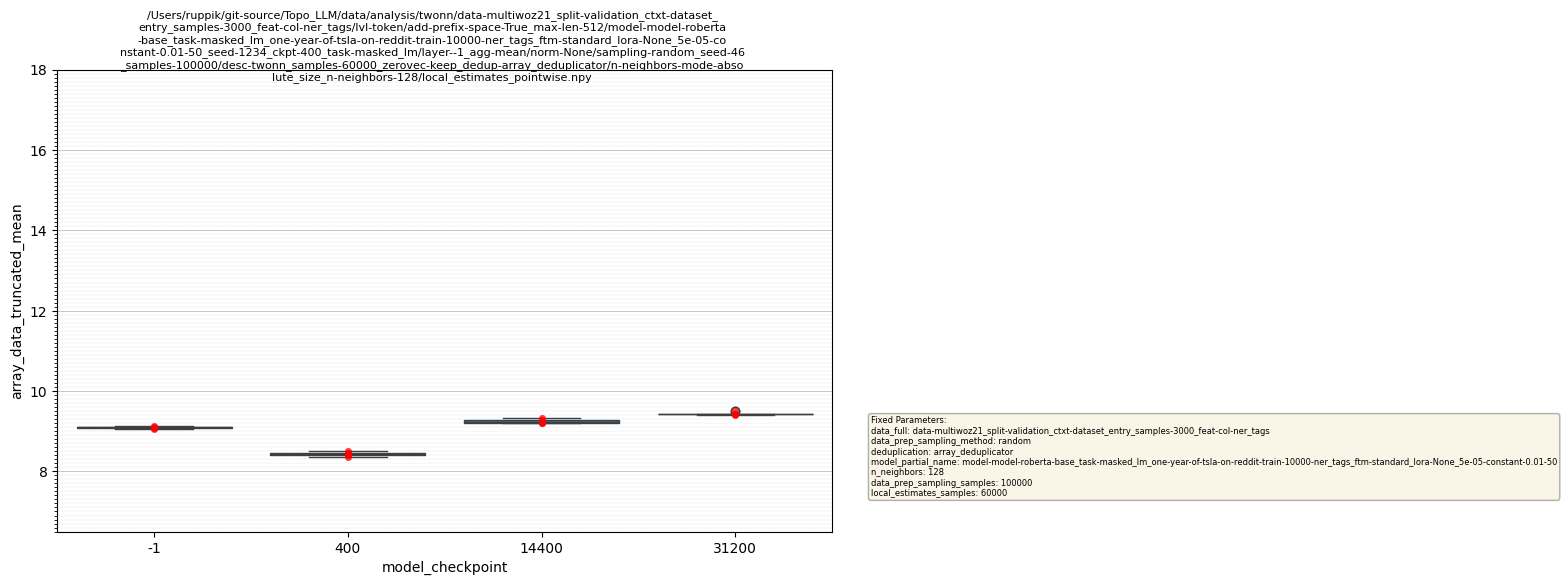

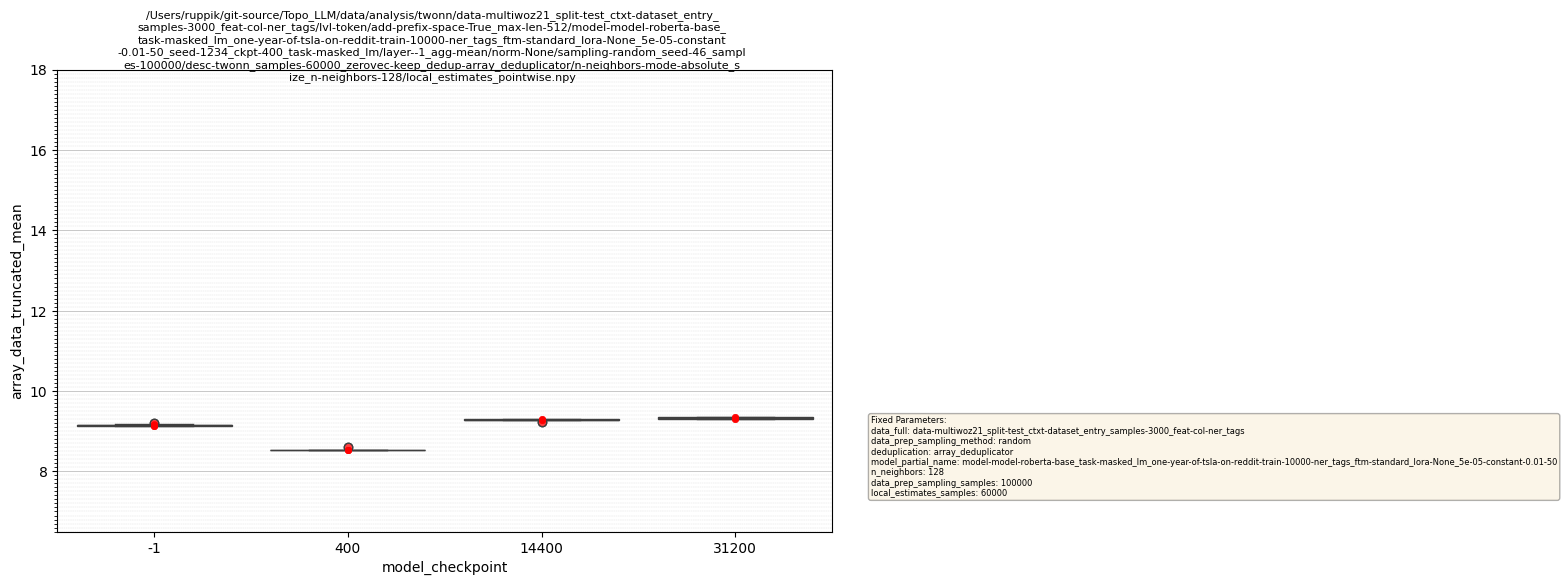

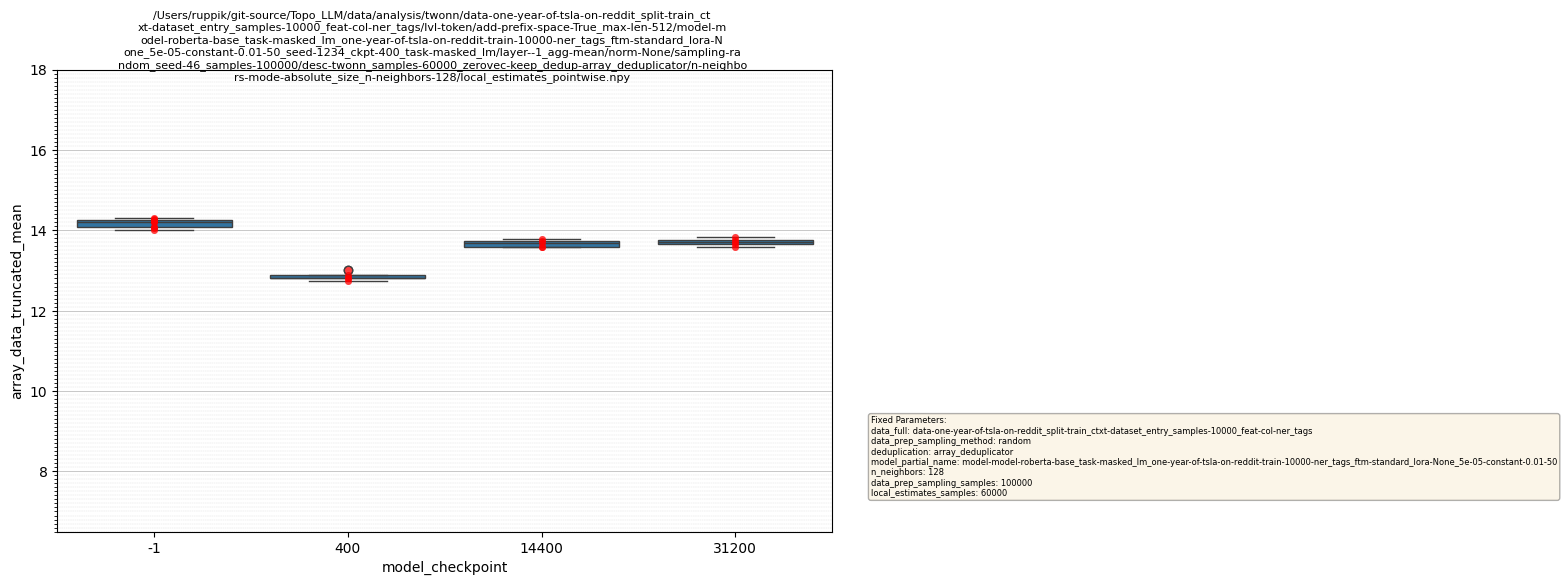

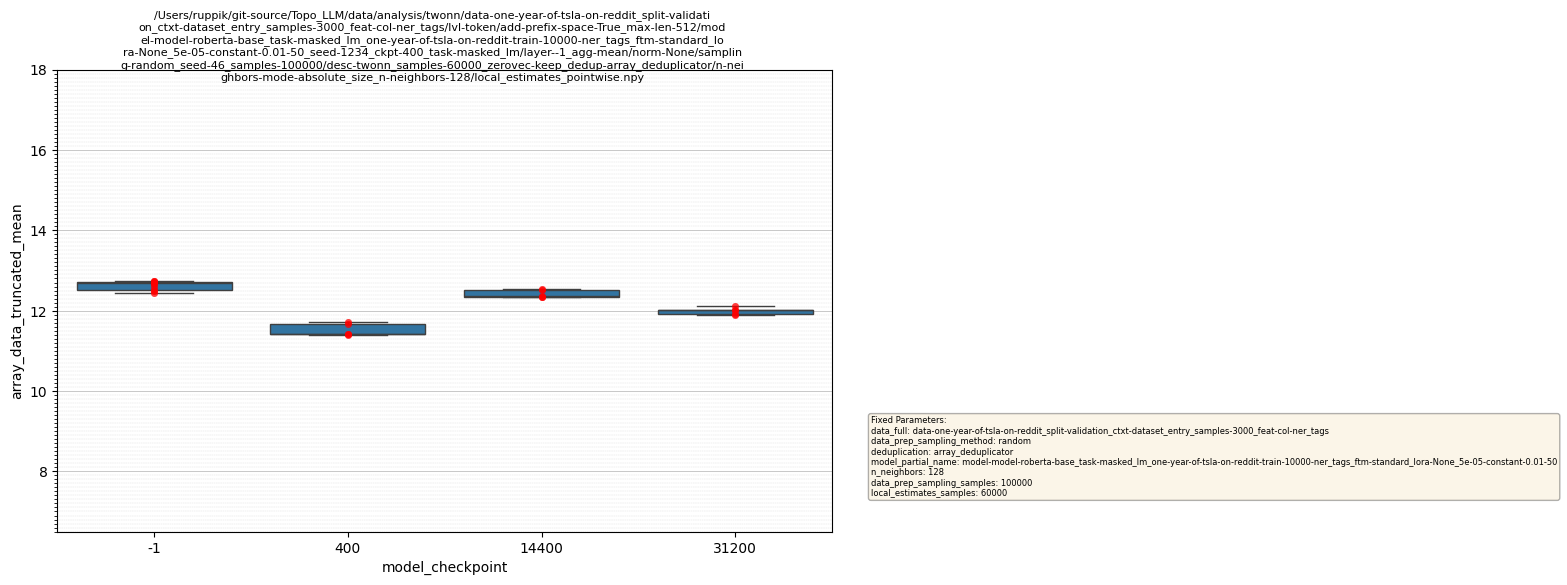

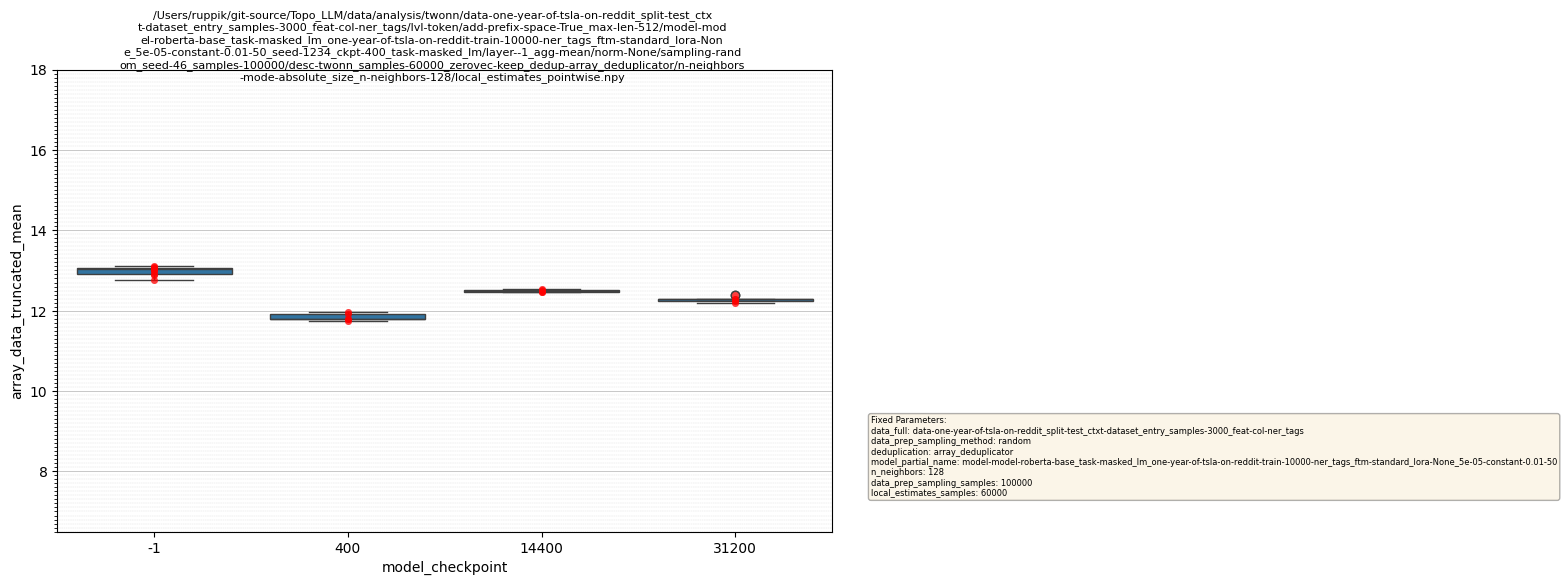

In [7]:
from itertools import product

data_full_list_to_process = [
    "data-multiwoz21_split-train_ctxt-dataset_entry_samples-10000_feat-col-ner_tags",
    "data-multiwoz21_split-validation_ctxt-dataset_entry_samples-3000_feat-col-ner_tags",
    "data-multiwoz21_split-test_ctxt-dataset_entry_samples-3000_feat-col-ner_tags",
    "data-one-year-of-tsla-on-reddit_split-train_ctxt-dataset_entry_samples-10000_feat-col-ner_tags",
    "data-one-year-of-tsla-on-reddit_split-validation_ctxt-dataset_entry_samples-3000_feat-col-ner_tags",
    "data-one-year-of-tsla-on-reddit_split-test_ctxt-dataset_entry_samples-3000_feat-col-ner_tags",
]

model_partial_name_list_to_process = [
    # "model-model-roberta-base_task-masked_lm_multiwoz21-train-10000-ner_tags_ftm-standard_lora-None_5e-05-constant-0.01-50",
    "model-model-roberta-base_task-masked_lm_one-year-of-tsla-on-reddit-train-10000-ner_tags_ftm-standard_lora-None_5e-05-constant-0.01-50",
]

for data_full, model_partial_name in product(data_full_list_to_process, model_partial_name_list_to_process):
    concatenated_filters_dict = {
        "data_full": data_full,
        "data_prep_sampling_method": "random",
        "deduplication": "array_deduplicator",
        "model_partial_name": model_partial_name,
        "n_neighbors": 128,
        "data_prep_sampling_samples": 100_000,
        "local_estimates_samples": 60_000,
    }

    create_histograms_over_model_checkpoints(
        concatenated_filters_dict=concatenated_filters_dict,
    )

In [ ]:
filtered_concatenated_df["model_partial_name"].unique()

In [ ]:
data_folder_list: list[str] = [
    "data-multiwoz21_split-train_ctxt-dataset_entry_samples-10000_feat-col-ner_tags/",
    "data-multiwoz21_split-validation_ctxt-dataset_entry_samples-3000_feat-col-ner_tags/",
    "data-multiwoz21_split-test_ctxt-dataset_entry_samples-3000_feat-col-ner_tags/",
    "data-one-year-of-tsla-on-reddit_split-train_ctxt-dataset_entry_samples-10000_feat-col-ner_tags/",
    "data-one-year-of-tsla-on-reddit_split-validation_ctxt-dataset_entry_samples-3000_feat-col-ner_tags/",
]

model_folder_list: list[str] = [
    "model-roberta-base_task-masked_lm/",
]

selected_data_folder = data_folder_list[4]
selected_model_folder = model_folder_list[0]

file_path = pathlib.Path(
    comparisons_folder_base_path,
    selected_data_folder,
    "lvl-token/add-prefix-space-True_max-len-512/",
    selected_model_folder,
    "layer--1_agg-mean/norm-None/",
    "full_local_estimates_df.csv",
)

results_base_directory_path: pathlib.Path = file_path.parent

local_estimates_df: pd.DataFrame = pd.read_csv(
    filepath_or_buffer=file_path,
)

# Select a subset of the data with the same parameters.
# This allows comparing over different seeds.
#
# We do not fix the local_estimates_samples,
# since we want to compare the results for different sample sizes.

filters_dict = {
    "data_prep_sampling_method": "random",
    "deduplication": "array_deduplicator",
    "n_neighbors": 128,
    "data_prep_sampling_samples": 50000,
}

subset_local_estimates_df = filter_dataframe_based_on_filters_dict(df=local_estimates_df, filters_dict=filters_dict)

subset_local_estimates_df.describe()